#**Fine-Tune Llama 2**


#**Gerekli paketler**

In [1]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7

In [2]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

#**Llama 2'de chat için kullanılan modellerde aşağıdaki template kullanılır.**

System Prompt (opsiyonel) : modele rehberlik etmekete.


User prompt (gerekli) : kullanıcı talimatlarını içerir.


Model Answer (gerekli)

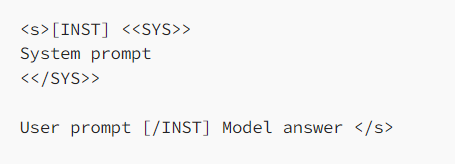

Llama 2 templateine uygun data : https://huggingface.co/datasets/mertbozkurt/llama2-TR-recipe

Eğer Llama 2 modelinin chat verisyonu yerine ana versiyonunu kullnılacaksa spesifik prompt' gerek yok.

#**Llama 2 Fine-tune**

Full fine-tuning düşük ram veya ekran kartı imkanlarıyla mümkün değildir. Bu yüzden parameter-efficient fine-tuning (PEFT) tekniklerini kullanmak gerekir.( LoRA/QLoRA)

En iyi şekilde ihtiyaçları düşürmek için QLoRA ile 4-bit precision kullancağız.

* QLoRA rank :64
* scaling parameter: 16.
* Llama 2 model  4-bit precision, NF4 type
* one epoch

In [3]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "mertbozkurt/llama2-TR-recipe"

# Fine-tuned model name
new_model = "Llama-2-7b-chat-finetune"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

#**Fine-tuning process**

1. Veri setini yükleme. Veri seti eğer uygun formatta değilse veya birden çok veri seti kullanılacaksa uygun şekilde değiştirilmeli.

2. Daha sonra, 4 bitlik quantization için bitsandbytes ları yapılandırıyoruz.


3. Daha sonra Llama 2 modelini 4 bit ve  ilgili tokenizer ile GPU'ya yüklüyoruz.


4. Son olarak QLoRA için konfigürasyonları, düzenli eğitim parametrelerini yüklüyoruz ve her şeyi SFTTrainer'a aktarıyoruz.

In [4]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
)

# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentran

Step,Training Loss
25,2.365600
50,1.843900
75,1.420200
100,1.204200
125,1.115900
150,0.998600
175,0.992500
200,0.918900
225,0.962100
250,0.905400


##**Tensorboard dan görüntüleyelim**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir results/runs

#**Modelin denenmesi**

In [14]:
# Ignore warnings
logging.set_verbosity(logging.CRITICAL)

# Run text generation pipeline with our next model
prompt = " köfte nasıl yapılır?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=500)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

<s>[INST]  köfte nasıl yapılır? [/INST] Köfte yapımında; orta boy derin bir tencere içine 1 adet yumurta kırın. (Yumurtanın kırımını azar azar sıcak olacaktır). Ardından 1 su bardağı sıvı yağ, 1 çay bardağı kadar tuz ve 1 çay bardağı kadar kırmızı toz biber ekleyin. Tencerenin kapağını kapatın. Tencerenin içine 100 gr kıyma koyun. Kıymayı 1 dakika kadar kavurun.Daha sonra tencere içine 100 gr kıyma koyun. Kıymayı 1 dakika kadar daha kavurun. Ardından tencere içine 100 gr kıyma koyun. Kıymayı 1 dakika kadar daha kavurun. Son olarak tencere içine 100 gr kıyma koyun. Kıymayı 1 dakika kadar daha kavurun. Tencerenin kapağını kapatın. Köfte harcını 15 dakika kadar kavurun.Diğer tarafta köfte harcının üzerine 1 su bardağı kadar un ekleyin. Köfte harcını 15 dakika kadar daha kavurun. Ardından tencerenin kapağını kapatın. Köfte harcını 15 dakika kadar daha dinlenmeye bırakın.Daha sonra köfte harcını çok fazla dinlenmeden önce 10 dakika kadar


#**Yeni Llama2 Modeli**

Modeli depolamak için LoRA dan gelen ağırlıkları ana modelle birleştirmeliyiz.

In [8]:
# Reload model in FP16 and merge it with LoRA weights
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

# Reload tokenizer to save it
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

#**Modeli Hugging Face Hub'a yüklemek**

In [9]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!huggingface-cli login

model.push_to_hub("mertbozkurt/Llama-2-7b-chat-finetune", check_pr=True)

tokenizer.push_to_hub("mertbozkurt/Llama-2-7b-chat-finetune",check_pr=True)
